In [1]:
# cargar datos desde csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import scipy.stats as stats

In [2]:


# el número de viajes de cada compañía de taxis el 15 y 16 de noviembre de 2017.
df = pd.read_csv('moved_project_sql_result_01.csv')
# el promedio de viajes que terminaron en cada barrio en noviembre de 2017.
df_avg_trips = pd.read_csv('moved_project_sql_result_04.csv')
df_weather = pd.read_csv('moved_project_sql_result_07.csv')

# Explorar y visualizar los datos 🔎

In [3]:
def analyze_dfs(dfs, names):
    """
    Analiza una lista de DataFrames y muestra:
    - Las primeras 5 filas
    - Información general del DataFrame
    - Estadísticas descriptivas
    - Valores nulos
    - Valores únicos por columna

    :param dfs: Lista de DataFrames a analizar.
    :param names: Lista de nombres para los DataFrames.
    """
    for df, name in zip(dfs, names):
        print(f"\n📌 Análisis del DataFrame: {name}\n")

        # Primeras filas
        print("🔹 Primeras filas:")
        print(df.head(), "\n")

        # Información general
        print("🔹 Información general:")
        print(df.info(), "\n")

        # Estadísticas descriptivas
        print("🔹 Estadísticas descriptivas:")
        print(df.describe(), "\n")

        # Valores nulos
        print("🔹 Valores nulos por columna:")
        print(df.isnull().sum(), "\n")

        # Valores únicos
        print("🔹 Valores únicos por columna:")
        print(df.nunique(), "\n")

        print("=" * 80)  # Separador visual para cada DataFrame


# Aplicar la función a los DataFrames cargados
analyze_dfs([df, df_avg_trips, df_weather], ["df1", "df_avg_trips", "df_weather"])


📌 Análisis del DataFrame: df1

🔹 Primeras filas:
                      company_name  trips_amount
0                        Flash Cab         19558
1        Taxi Affiliation Services         11422
2                 Medallion Leasin         10367
3                       Yellow Cab          9888
4  Taxi Affiliation Service Yellow          9299 

🔹 Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
None 

🔹 Estadísticas descriptivas:
       trips_amount
count     64.000000
mean    2145.484375
std     3812.310186
min        2.000000
25%       20.750000
50%      178.500000
75%     2106.500000
max    19558.000000 

🔹 Valores nulos por columna:
company_name    0
trips_amount    0
dtype: int64 

🔹 Valores úni

# Limpieza de Datos 🧹

In [4]:
def clean_data(df, columns):
    # Trim spaces in specified columns
    for column in columns:
        if column in df.columns:
            df[column] = df[column].str.strip().str.lower()

    # Drop duplicates
    df.drop_duplicates(inplace=True)
    df.dropna(inplace=True)

    return df


def clean_company_name(name):

    cleaned_name = re.sub(r'(\d+\s*-\s*\d+\s*|\d{4}\s*-\s*|\s*-\s*)', '', name).strip()
    return cleaned_name

In [5]:
clean_data(df, 'company_name')
clean_data(df_avg_trips, 'dropoff_location_name')
clean_data(df_weather, ["start_ts", "weather_conditions"])

df["cleaned_company_name"] = df["company_name"].apply(clean_company_name)
df_avg_trips['average_trips'] = df_avg_trips['average_trips'].round(2)
df_weather['start_ts'] = pd.to_datetime(df_weather['start_ts'])
df_weather['duration_seconds'] = df_weather['duration_seconds'].astype(int)

In [6]:
# Ordenar los datos por la fecha y hora de inicio de la ruta
df_weather = df_weather.sort_values(by=['duration_seconds'], ascending=True)
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 871 entries, 168 to 354
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   start_ts            871 non-null    datetime64[ns]
 1   weather_conditions  871 non-null    object        
 2   duration_seconds    871 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 27.2+ KB


In [7]:
sin_datos = df_weather[(df_weather['start_ts'] == 0) & (df_weather['duration_seconds'] == 0)]
sin_datos

count = df_weather[df_weather['duration_seconds'] == 0].shape[0]
print(count)

# Eliminar filas con duracion en segundos 0
df_weather = df_weather[ (df_weather['duration_seconds'] != 0)]


# Imprimir los primeros y últimos 5 filas de df_weather para verificar que los cambios se hayan efectuado correctamente.
print(df_weather.head(5))
print(df_weather.tail(5))

6
               start_ts weather_conditions  duration_seconds
15  2017-11-25 13:00:00               good                60
424 2017-11-11 13:00:00               good               420
860 2017-11-04 18:00:00                bad               480
203 2017-11-18 00:00:00                bad               480
874 2017-11-04 05:00:00               good              1018
               start_ts weather_conditions  duration_seconds
79  2017-11-11 15:00:00               good              4800
276 2017-11-18 12:00:00                bad              4980
583 2017-11-11 16:00:00               good              4980
619 2017-11-25 14:00:00               good              6420
354 2017-11-25 11:00:00               good              7440


# Enriquecer los datos

In [8]:
# Agregar columna a df_weather con la duracion en minutos y otra columna con la duracion en horas 
df_weather['date'] = df_weather['start_ts'].dt.floor('D')
df_weather['duration_minutes'] = round(df_weather['duration_seconds'] / 60, 2)
df_weather['day_of_week'] = df_weather['start_ts'].dt.day_name()

df_weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 865 entries, 15 to 354
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   start_ts            865 non-null    datetime64[ns]
 1   weather_conditions  865 non-null    object        
 2   duration_seconds    865 non-null    int64         
 3   date                865 non-null    datetime64[ns]
 4   duration_minutes    865 non-null    float64       
 5   day_of_week         865 non-null    object        
dtypes: datetime64[ns](2), float64(1), int64(1), object(2)
memory usage: 47.3+ KB


# 📊 GRAFICAS 

### Los 10 barrios principales por número de finalizaciones ✅ 🏁

In [9]:
# Top 10 average_trips descending
top_10_neighborhoods = df_avg_trips.sort_values(
    by='average_trips', ascending=False).head(10).copy()
print("Top 10 barrios con promedio de viajes en noviembre de 2017:")
print(top_10_neighborhoods)
print("-------------------------------------------------")

Top 10 barrios con promedio de viajes en noviembre de 2017:
  dropoff_location_name  average_trips
0                  Loop       10727.47
1           River North        9523.67
2         Streeterville        6664.67
3             West Loop        5163.67
4                O'Hare        2546.90
5             Lake View        2420.97
6            Grant Park        2068.53
7         Museum Campus        1510.00
8            Gold Coast        1364.23
9    Sheffield & DePaul        1259.77
-------------------------------------------------


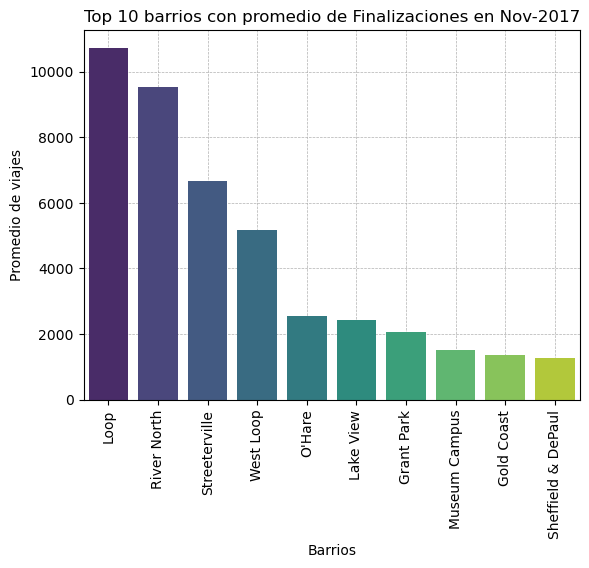

In [10]:
sns.barplot(x="dropoff_location_name", y="average_trips", 
            data=top_10_neighborhoods, palette="viridis", dodge=False)
plt.xticks(rotation=90)
plt.gca().set_axisbelow(True)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('Barrios')
plt.ylabel('Promedio de viajes')
plt.title('Top 10 barrios con promedio de Finalizaciones en Nov-2017')
plt.show()

> Las empresas Loop y River North son las que tienen en promedio mas viajes finalizados (completados) que el resto de compañias.


### Top 10 compañias con más viajes 🏢

In [11]:
top_10_companies = df.sort_values(
    by='trips_amount', ascending=False).head(10).copy()
top_10_companies['trips_amount'] = top_10_companies['trips_amount']
top_10_companies

,company_name,trips_amount,cleaned_company_name
0,Flash Cab,19558,Flash Cab
1,Taxi Affiliation Services,11422,Taxi Affiliation Services
2,Medallion Leasin,10367,Medallion Leasin
3,Yellow Cab,9888,Yellow Cab
4,Taxi Affiliation Service Yellow,9299,Taxi Affiliation Service Yellow
5,Chicago Carriage Cab Corp,9181,Chicago Carriage Cab Corp
6,City Service,8448,City Service
7,Sun Taxi,7701,Sun Taxi
8,Star North Management LLC,7455,Star North Management LLC
9,Blue Ribbon Taxi Association Inc.,5953,Blue Ribbon Taxi Association Inc.


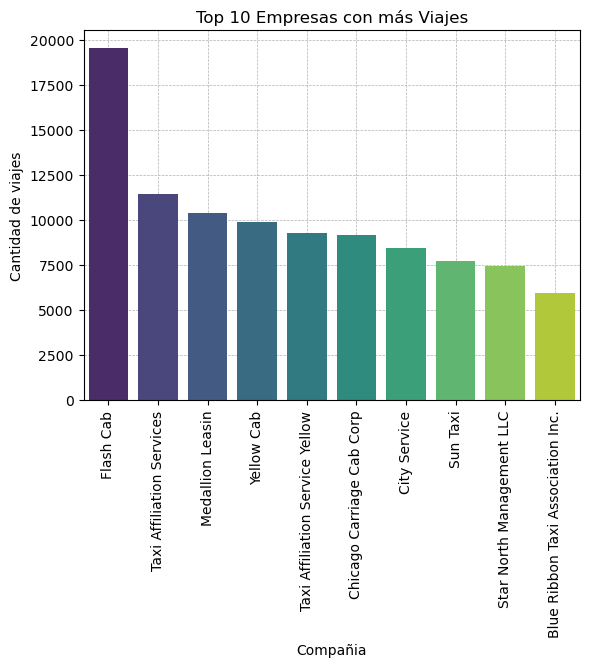

In [12]:

sns.barplot(x="cleaned_company_name", y="trips_amount",
            data=top_10_companies, palette="viridis", dodge=False)
plt.xticks(rotation=90)
plt.gca().set_axisbelow(True)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('Compañia')
plt.ylabel('Cantidad de viajes')
plt.title('Top 10 Empresas con más Viajes')
plt.show()

A diferencia de nuestro pimer grafico, a pesar de que Loop sea la compañia con el promedio de viajes completados mas altos de todas, esta no es parte de las 10 compañias con mas viajes, siendo Flash Cab quien lidera esta categoria, pero con mucho menos viajes en promedio completados que Loop y River North.

### Empresas de taxis 🚖 y número de viajes 🧳

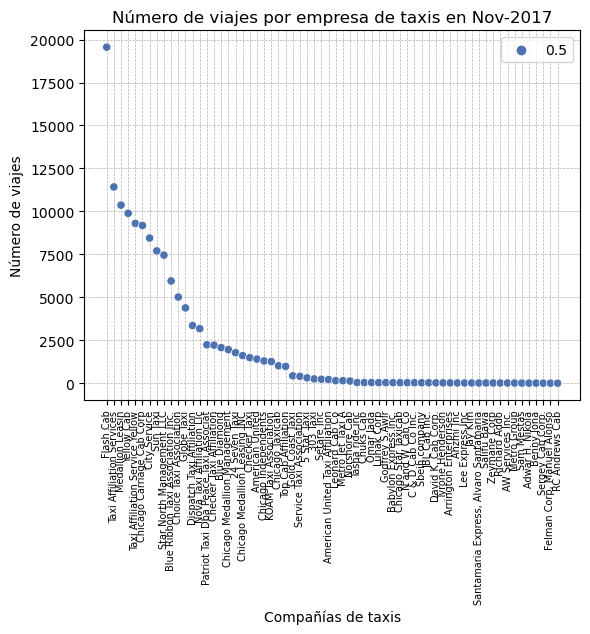

In [13]:
sns.scatterplot(x="cleaned_company_name", y="trips_amount", hue=0.5,
                data=df, palette="deep")
plt.xticks(rotation=90, fontsize=7)
plt.gca().set_axisbelow(True)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('Compañías de taxis')
plt.ylabel('Número de viajes')
plt.title('Número de viajes por empresa de taxis en Nov-2017')
plt.show()

Al igual que el grafico anterior, los viajes mas altos para noviembre 2017 estan relacionados a la compañia Flash Cab. 

### Distribución de Viajes por Empresa

In [14]:
df

,company_name,trips_amount,cleaned_company_name
0,Flash Cab,19558,Flash Cab
1,Taxi Affiliation Services,11422,Taxi Affiliation Services
2,Medallion Leasin,10367,Medallion Leasin
3,Yellow Cab,9888,Yellow Cab
4,Taxi Affiliation Service Yellow,9299,Taxi Affiliation Service Yellow
...,...,...,...
59,4053 - 40193 Adwar H. Nikola,7,Adwar H. Nikola
60,2733 - 74600 Benny Jona,7,Benny Jona
61,5874 - 73628 Sergey Cab Corp.,5,Sergey Cab Corp.
62,"2241 - 44667 - Felman Corp, Manuel Alonso",3,"Felman Corp, Manuel Alonso"


/var/folders/09/b66xbcrn5ms766myp019sck00000gn/T/ipykernel_10504/3532460501.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df_sorted, x='trips_amount',
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


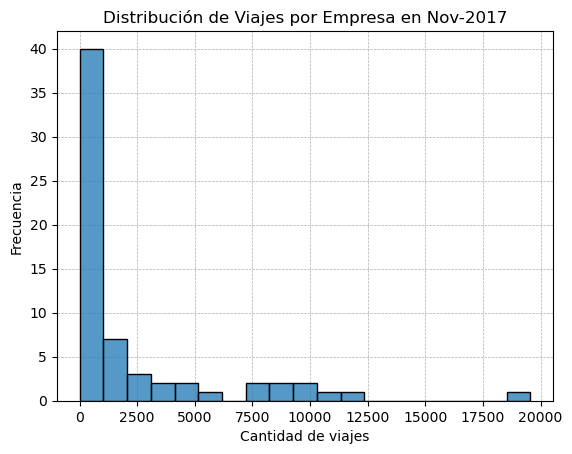

In [15]:
df_sorted = df.sort_values(by='trips_amount', ascending=False)

sns.histplot(data=df_sorted, x='trips_amount',
             palette='viridis')
plt.gca().set_axisbelow(True)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('Cantidad de viajes')
plt.ylabel('Frecuencia')
plt.title('Distribución de Viajes por Empresa en Nov-2017')
plt.show()

Vemos en esta distribución que hay compañias que tiene mas frecuencia de viajes que otras y es una diferencia importante, donde se ve un sesgo bastante evidente, al parecer los usuarios prefieren una compañia en particular. 

### Destinos con mas viajes Promedio 📍

In [16]:

top_10_locations = df_avg_trips.sort_values(
    by='average_trips', ascending=False).head(10).copy()
top_10_locations['average_trips'] = top_10_locations['average_trips']
top_10_locations

,dropoff_location_name,average_trips
0,Loop,10727.47
1,River North,9523.67
2,Streeterville,6664.67
3,West Loop,5163.67
4,O'Hare,2546.90
5,Lake View,2420.97
6,Grant Park,2068.53
7,Museum Campus,1510.00
8,Gold Coast,1364.23
9,Sheffield & DePaul,1259.77


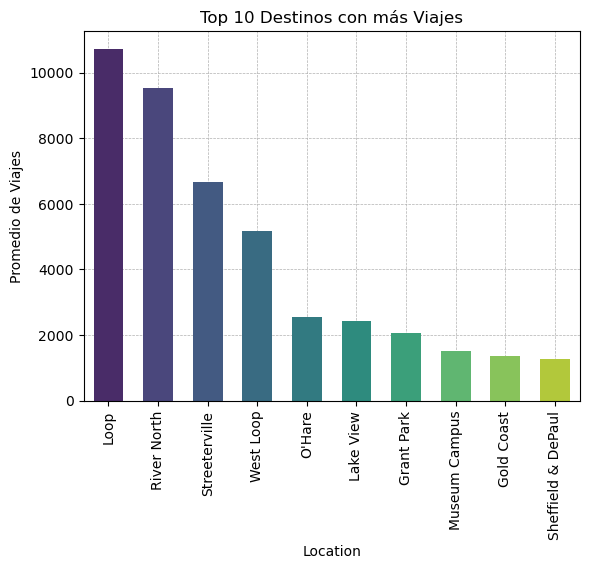

In [17]:

bar_plot = sns.barplot(x="dropoff_location_name", y="average_trips",
                       data=top_10_neighborhoods,palette="viridis", dodge=False, width=0.6)

plt.xticks(rotation=90)
plt.gca().set_axisbelow(True)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('Location')
plt.ylabel('Promedio de Viajes')
plt.title('Top 10 Destinos con más Viajes')
plt.show()

> Loop, River North y Streeterville son los destinos mas populares.

# PRUEBA DE HIPOTESIS ϐ

In [18]:
print(df_weather.info())
print(df_weather.head())

<class 'pandas.core.frame.DataFrame'>
Index: 865 entries, 15 to 354
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   start_ts            865 non-null    datetime64[ns]
 1   weather_conditions  865 non-null    object        
 2   duration_seconds    865 non-null    int64         
 3   date                865 non-null    datetime64[ns]
 4   duration_minutes    865 non-null    float64       
 5   day_of_week         865 non-null    object        
dtypes: datetime64[ns](2), float64(1), int64(1), object(2)
memory usage: 47.3+ KB
None
               start_ts weather_conditions  duration_seconds       date  \
15  2017-11-25 13:00:00               good                60 2017-11-25   
424 2017-11-11 13:00:00               good               420 2017-11-11   
860 2017-11-04 18:00:00                bad               480 2017-11-04   
203 2017-11-18 00:00:00                bad               480 2017

## Prueba la hipótesis:

> **"La duración promedio de los viajes desde el Loop hasta el Aeropuerto Internacional O'Hare cambia los sábados lluviosos".**



----------------------------------------------------------------
> #### **Como queremos saber si los sabados lluviosos 🌧️ son diferentes ya sea hacia arriba o hacia abajo respecto de los sabados con buen clima 🌞, usarmeos una hipotesis de dos colas.**

> Utilizaremos la prueba t de Student para muestras independientes. Esta prueba es adecuada para comparar las medias de dos grupos independientes.


In [19]:
# Agrupar los datos por clima y obtener su promedio de duracion en minutos 
grouped_weather = df_weather.groupby("weather_conditions")["duration_minutes"].mean()
grouped_weather

weather_conditions
bad     40.153716
good    34.154282
Name: duration_minutes, dtype: float64

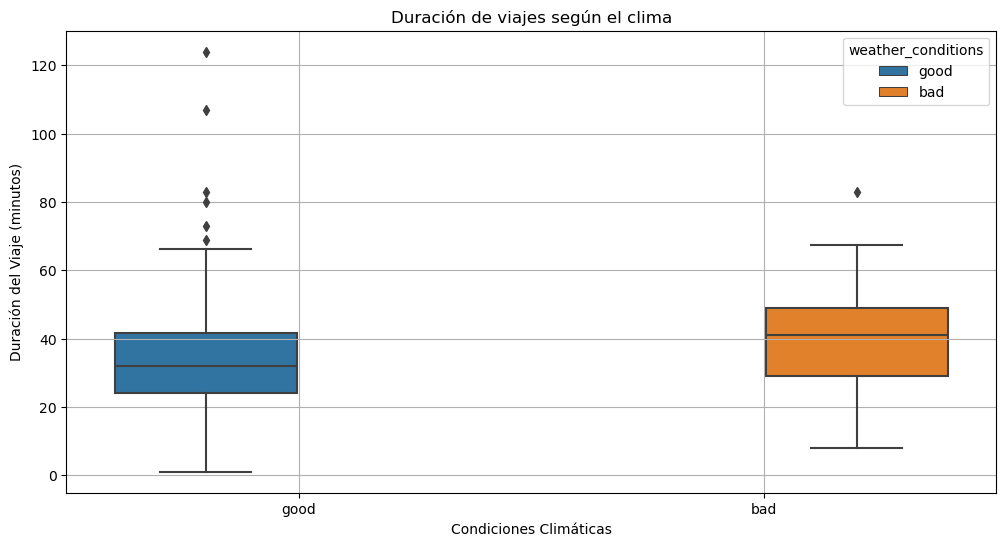

In [20]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_weather['weather_conditions'],
            y=df_weather['duration_minutes'], hue=df_weather["weather_conditions"])
plt.xlabel("Condiciones Climáticas")
plt.ylabel("Duración del Viaje (minutos)")
plt.title("Duración de viajes según el clima")
plt.grid(True)
plt.show()

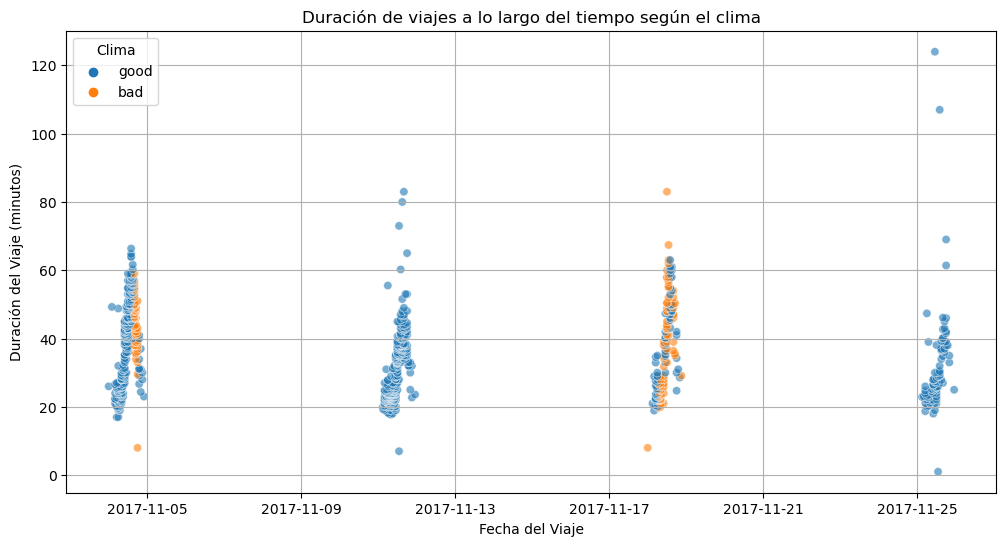

In [21]:

# Scatter Plot: Relación entre el tiempo y la duración del viaje
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df_weather["start_ts"], y=df_weather["duration_minutes"],
                hue=df_weather["weather_conditions"], alpha=0.6)
plt.xlabel("Fecha del Viaje")
plt.ylabel("Duración del Viaje (minutos)")
plt.title("Duración de viajes a lo largo del tiempo según el clima")
plt.legend(title="Clima")
plt.grid(True)
plt.show()

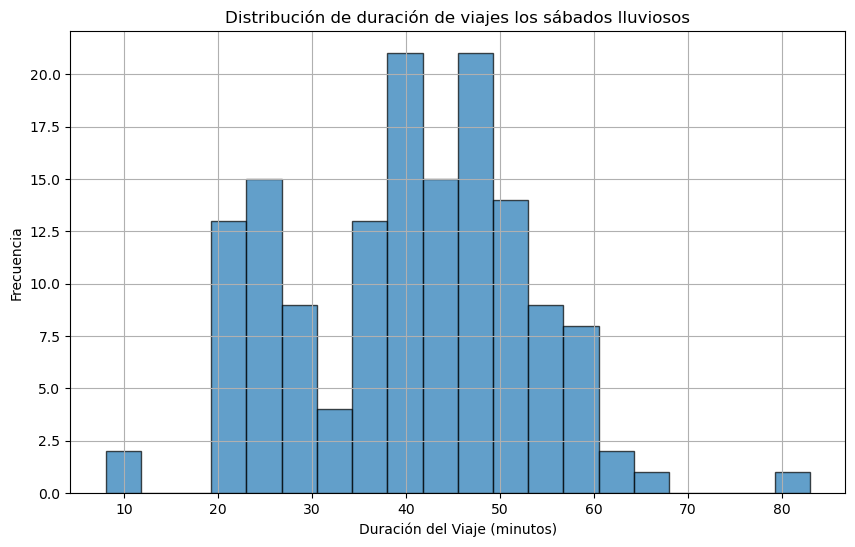

In [22]:
df_saturday_rainy = df_weather[(df_weather['day_of_week'] == 'Saturday') &
                               (df_weather['weather_conditions'].str.contains('bad', case=False, na=False))]

# Histograma de duración de viajes los sábados lluviosos
plt.figure(figsize=(10, 6))
plt.hist(df_saturday_rainy['duration_minutes'],
         bins=20, edgecolor='black', alpha=0.7)
plt.xlabel("Duración del Viaje (minutos)")
plt.ylabel("Frecuencia")
plt.title("Distribución de duración de viajes los sábados lluviosos")
plt.grid(True)
plt.show()

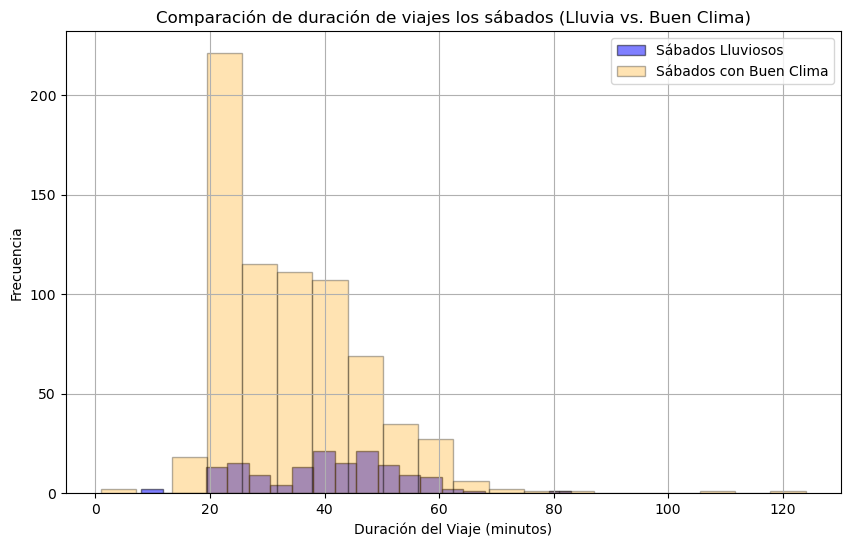

In [23]:
# Filtrar los datos de sábados con clima lluvioso y bueno
df_saturday_rainy = df_weather[(df_weather['day_of_week'] == 'Saturday') &
                               (df_weather['weather_conditions'].str.contains('bad', case=False, na=False))]

df_saturday_good = df_weather[(df_weather['day_of_week'] == 'Saturday') &
                              (df_weather['weather_conditions'].str.contains('good', case=False, na=False))]

# Crear histograma comparativo
plt.figure(figsize=(10, 6))

plt.hist(df_saturday_rainy['duration_minutes'], bins=20, alpha=0.5,
         label="Sábados Lluviosos", edgecolor='black', color='blue')
plt.hist(df_saturday_good['duration_minutes'], bins=20, alpha=0.3,
         label="Sábados con Buen Clima", edgecolor='black', color='orange')

plt.xlabel("Duración del Viaje (minutos)")
plt.ylabel("Frecuencia")
plt.title("Comparación de duración de viajes los sábados (Lluvia vs. Buen Clima)")
plt.legend()
plt.grid(True)
plt.show()

# 1️⃣ Definir la hipótesis

## Hipótesis Nula (𝐻₀):
"La duración promedio de los viajes desde el Loop hasta el Aeropuerto Internacional O'Hare en sábados lluviosos es igual a la duración en sábados con buen clima."

Matemáticamente:
$$
H_0: \mu_{\text{sábados lluviosos}} = \mu_{\text{sábados buen clima}}
$$

## Hipótesis Alternativa (𝐻ₐ):
"La duración promedio de los viajes desde el Loop hasta el Aeropuerto Internacional O'Hare en sábados lluviosos es diferente de la duración en sábados con buen clima."

Matemáticamente:
$$
H_A: \mu_{\text{sábados lluviosos}} \neq \mu_{\text{sábados buen clima}}
$$

Como no estamos asumiendo que la lluvia solo aumenta o solo disminuye la duración, usamos una prueba de dos colas.

# 2️⃣ Elegir el nivel de significancia (𝛼)

Normalmente, 𝛼 = 0.05 es el estándar en estudios estadísticos.
Si queremos una prueba más estricta, podríamos usar 𝛼 = 0.01.
Para este análisis, elegimos:

$$
\alpha = 0.05
$$

# 3️⃣ Verificar si las varianzas son iguales (Prueba de Levene)

Antes de hacer la prueba t de Student, necesitamos verificar si las varianzas de ambos grupos son iguales.
Usaremos la prueba de Levene, que nos dice si los dos conjuntos de datos tienen una varianza similar o no.

**Hipótesis Nula (𝐻₀) de Levene**: Las varianzas son iguales.

**Hipótesis Alternativa (𝐻ₐ) de Levene**: Las varianzas son diferentes.

Si el p-valor de la prueba de Levene es mayor que 𝛼, asumimos varianzas iguales y usamos la prueba t con varianzas iguales.
Si el p-valor es menor que 𝛼, usamos la prueba t con varianzas desiguales.

In [ ]:
import scipy.stats as stats

df_saturday_rainy = df_weather[(df_weather['day_of_week'] == 'Saturday') &
                               (df_weather['weather_conditions'].str.contains('bad', case=False, na=False))]

df_saturday_good = df_weather[(df_weather['day_of_week'] == 'Saturday') &
                              (df_weather['weather_conditions'].str.contains('good', case=False, na=False))]

durations_rainy = df_saturday_rainy['duration_minutes']
durations_good = df_saturday_good['duration_minutes']

# Prueba de Levene para comparar varianzas
levene_stat, levene_p = stats.levene(durations_rainy, durations_good)

print(
    f"Prueba de Levene: estadístico={levene_stat:.4f}, p-valor={levene_p:.4f}")

# Elección de varianzas iguales o diferentes
equal_var = levene_p > 0.05  # Si p > 0.05, asumimos varianzas iguales

if equal_var:
    print("No se puede rechazar la hipótesis nula de Levene: Las varianzas son iguales.")
else:
    print("Rechazamos la hipótesis nula de Levene: Las varianzas son significativamente diferentes.")


Prueba de Levene: estadístico=0.0521, p-valor=0.8194
No se puede rechazar la hipótesis nula de Levene: Las varianzas son iguales.


# 4️⃣ Aplicar la prueba t de Student

La prueba t nos permitirá comparar las medias de los dos grupos. Dependiendo del resultado de la prueba de Levene:

- Si las varianzas son iguales → usamos `equal_var=True` en la prueba t.
- Si las varianzas son diferentes → usamos `equal_var=False` en la prueba t.

El resultado nos dará un p-valor:

- Si \( p \leq \alpha \) → Rechazamos \( H_0 \), lo que significa que hay una diferencia significativa.
- Si \( p > \alpha \) → No podemos rechazar \( H_0 \), es decir, no hay evidencia suficiente para decir que la lluvia afecta la duración de los viajes.

In [ ]:

# Prueba t de Student (dos colas)
t_stat, p_value = stats.ttest_ind(
    durations_rainy, durations_good, equal_var=True)

print(
    f"Prueba t de Student: estadístico t={t_stat:.4f}, p-valor={p_value:.4f}")

# Interpretación de la prueba t
if p_value < 0.05:
    print("Rechazamos la hipótesis nula: Hay una diferencia significativa en la duración de los viajes.")
else:
    print("No se puede rechazar la hipótesis nula: No hay evidencia suficiente para afirmar que la lluvia afecta la duración de los viajes.")

Prueba t de Student: estadístico t=5.2914, p-valor=0.0000
Rechazamos la hipótesis nula: Hay una diferencia significativa en la duración de los viajes.


# 5️⃣ Interpretar los resultados 📄

 > ✅ **Al ser el p-valor de la prueba t es menor que 0.05, concluimos que la lluvia afecta la duración de los viajes.**

